In [15]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib import font_manager
import textwrap
import math

font_dirs = ['/home/ys792/.fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.style.use('default')
plt.rcParams["font.family"] = "Raleway"

In [39]:
class ComplexRadar():
    """
    Create a complex radar chart with different scales for each variable

    Parameters
    ----------
    fig : figure object
        A matplotlib figure object to add the axes on
    variables : list
        A list of variables
    ranges : list
        A list of tuples (min, max) for each variable
    n_ring_levels: int, defaults to 5
        Number of ordinate or ring levels to draw
    show_scales: bool, defaults to True
        Indicates if we the ranges for each variable are plotted
    format_cfg: dict, defaults to None
        A dictionary with formatting configurations

    """
    def __init__(self, fig, variables, ranges, n_ring_levels=5, show_scales=True, format_cfg=None):
        
        # Default formatting
        self.format_cfg = {
            # Axes
            # https://matplotlib.org/stable/api/figure_api.html
            'axes_args': {},
            # Tick labels on the scales
            # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.rgrids.html
            'rgrid_tick_lbls_args': {'fontsize':8},
            # Radial (circle) lines
            # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.grid.html
            'rad_ln_args': {},
            # Angle lines
            # https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D
            'angle_ln_args': {},
            # Include last value (endpoint) on scale
            'incl_endpoint':False,
            # Variable labels (ThetaTickLabel)
            'theta_tick_lbls':{'va':'top', 'ha':'center'},
            'theta_tick_lbls_txt_wrap':15,
            'theta_tick_lbls_brk_lng_wrds':False,
            'theta_tick_lbls_pad':25,
            # Outer ring
            # https://matplotlib.org/stable/api/spines_api.html
            'outer_ring':{'visible':True, 'color':'#d6d6d6'}
        }
        
        if format_cfg is not None:
            self.format_cfg = { k:(format_cfg[k]) if k in format_cfg.keys() else (self.format_cfg[k]) 
                 for k in self.format_cfg.keys()}        
        
        
        # Calculate angles and create for each variable an axes
        # Consider here the trick with having the first axes element twice (len+1)
        angles = np.arange(0, 360, 360./len(variables))
        axes = [fig.add_axes([0.1,0.1,0.9,0.9], 
                             polar=True,
                             label = "axes{}".format(i),
                             **self.format_cfg['axes_args']) for i in range(len(variables)+1)]
        
        # Ensure clockwise rotation (first variable at the top N)
        for ax in axes:
            ax.set_theta_zero_location('N')
            ax.set_theta_direction(-1)
            ax.set_axisbelow(True)
        
        # Writing the ranges on each axes
        for i, ax in enumerate(axes):

            # Here we do the trick by repeating the first iteration
            j = 0 if (i==0 or i==1) else i-1
            ax.set_ylim(*ranges[j])
            # Set endpoint to True if you like to have values right before the last circle
            grid = np.linspace(*ranges[j], num=n_ring_levels, 
                               endpoint=self.format_cfg['incl_endpoint'])
            gridlabel = ["{}".format(round(x,2)) for x in grid]
            gridlabel[0] = "" # remove values from the center
            lines, labels = ax.set_rgrids(grid, 
                              labels=gridlabel, 
                              angle=angles[j],
                              **self.format_cfg['rgrid_tick_lbls_args']
                              )
            
            ax.set_ylim(*ranges[j])
            ax.spines["polar"].set_visible(False)
            ax.grid(visible=False)
            
            if show_scales == False:
                ax.set_yticklabels([])

        # Set all axes except the first one unvisible
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            
        # Setting the attributes
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
        self.ax1 = axes[1]
        self.plot_counter = 0
        
        
        # Draw (inner) circles and lines
        self.ax.yaxis.grid(**self.format_cfg['rad_ln_args'])
        # Draw outer circle
        self.ax.spines['polar'].set(**self.format_cfg['outer_ring'])
        # Draw angle lines
        self.ax.xaxis.grid(**self.format_cfg['angle_ln_args'])

        # ax1 is the duplicate of axes[0] (self.ax)
        # Remove everything from ax1 except the plot itself
        self.ax1.axis('off')
        self.ax1.set_zorder(9)
        
        # Create the outer labels for each variable
        l, text = self.ax.set_thetagrids(angles, labels=variables)
        
        # Beautify them
        labels = [t.get_text() for t in self.ax.get_xticklabels()]
        labels = ['\n'.join(textwrap.wrap(l, self.format_cfg['theta_tick_lbls_txt_wrap'], 
                            break_long_words=self.format_cfg['theta_tick_lbls_brk_lng_wrds'])) for l in labels]
        self.ax.set_xticklabels(labels, **self.format_cfg['theta_tick_lbls'])
        
        for t,a in zip(self.ax.get_xticklabels(),angles):
            # if a == 0:
            #     t.set_ha('center')
            # elif a > 0 and a < 180:
            #     t.set_ha('left')
            # elif a == 180:
            #     t.set_ha('center')
            # else:
            #     t.set_ha('right')
            t.set_ha('center')

        self.ax.tick_params(axis='both', pad=self.format_cfg['theta_tick_lbls_pad'])


    def _scale_data(self, data, ranges):
        """Scales data[1:] to ranges[0]"""
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            assert (y1 <= d <= y2) or (y2 <= d <= y1), f"{d} not in range {y1} to {y2}"
        x1, x2 = ranges[0]
        d = data[0]
        sdata = [d]
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            sdata.append((d-y1) / (y2-y1) * (x2 - x1) + x1)
        return sdata
        
    def plot(self, data, *args, **kwargs):
        """Plots a line"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        self.plot_counter = self.plot_counter+1
    
    def fill(self, data, *args, **kwargs):
        """Plots an area"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        
    def use_legend(self, *args, **kwargs):
        """Shows a legend"""
        legend = self.ax1.legend(*args, **kwargs)
        for legobj in legend.legend_handles:
            legobj.set_linewidth(3.0)
    
    def set_title(self, title, pad=25, **kwargs):
        """Set a title"""
        self.ax.set_title(title,pad=pad, **kwargs)
    
    def set_text(self, *args, **kwargs):
        self.ax.set_text(*args, **kwargs)

/tmp/ipykernel_2282863/1783952481.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


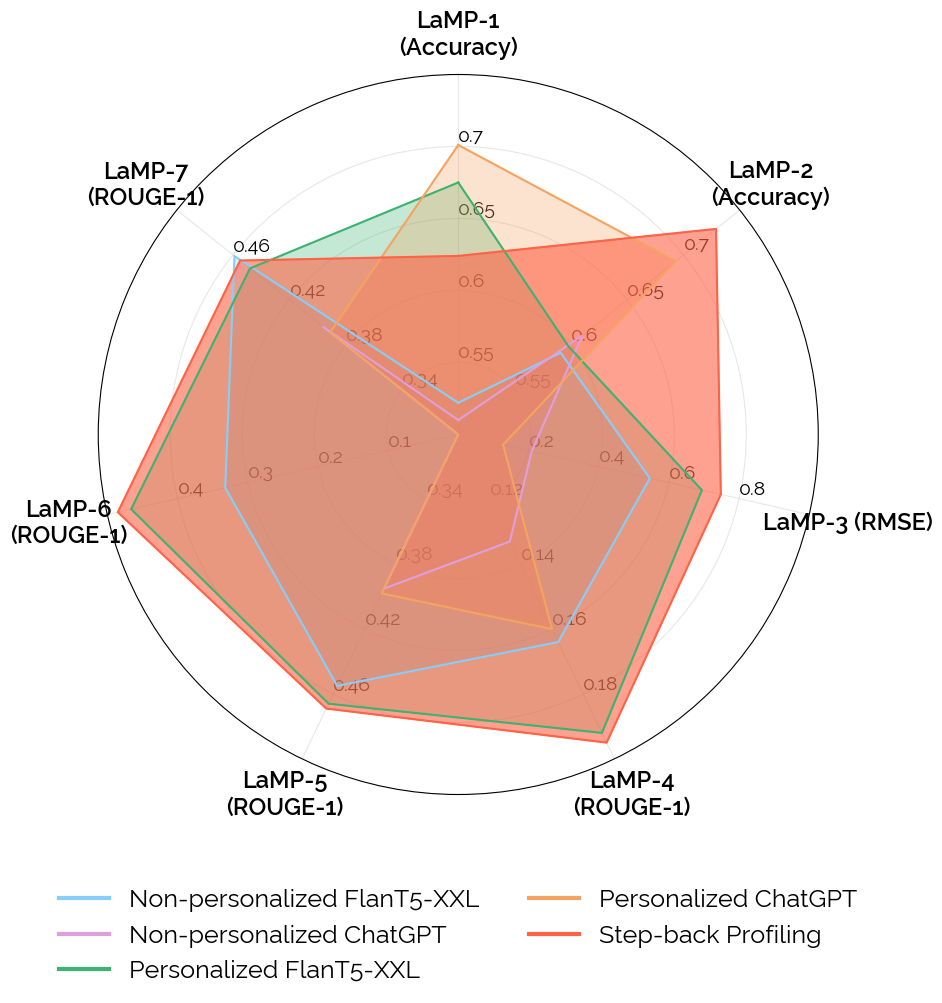

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import textwrap

# Assuming ComplexRadar class is already defined as per the provided code

# Data for the radar chart
labels = ["LaMP-1 (Accuracy)", "LaMP-2 (Accuracy)", "LaMP-3 (RMSE)", "LaMP-4 (ROUGE-1)", "LaMP-5 (ROUGE-1)", "LaMP-6 (ROUGE-1)", "LaMP-7 (ROUGE-1)"]
stats = {
    "Non-personalized FlanT5-XXL": [0.522, 0.591, 0.666, 0.164, 0.455, 0.332, 0.459],
    "Non-personalized ChatGPT": [0.510, 0.610, 0.977, 0.133, 0.395, 0, 0.396],
    "Personalized FlanT5-XXL": [0.675, 0.598, 0.584, 0.192, 0.466, 0.466, 0.448],
    "Personalized ChatGPT": [0.701, 0.693, 1.102, 0.160, 0.398, 0, 0.391],
    "Step-back Profiling": [0.624, 0.729, 0.559, 0.195, 0.469, 0.485, 0.455]
}

# Normalize RMSE values to [0, 1]
rmse_values = [1 / stats[method][2] for method in stats]
min_rmse = min(rmse_values) * 0.8
max_rmse = max(rmse_values) * 1.2

for method in stats:
    stats[method][2] = (1 / stats[method][2] - min_rmse) / (max_rmse - min_rmse)

ranges = [[0.5, 0.75], [0.5, 0.75], [0, 1], [0.1, 0.2], [0.3, 0.5], [0, 0.5], [0.3, 0.5]]
variables = labels

format_cfg = {
    'rad_ln_args': {'visible':True, 'alpha':0.3},
    'angle_ln_args': {'visible':True, 'alpha':0.3},
    'rgrid_tick_lbls_args': {'fontsize':14},
    'theta_tick_lbls_pad': 18,
    'outer_ring':{'visible':True, 'color':'#000000'},
    'theta_tick_lbls':{'va':'center', 'ha':'center', 'fontsize':17, 'fontweight':550},
}

fig1 = plt.figure(figsize=(8, 8))
radar = ComplexRadar(fig1, variables, ranges, n_ring_levels=5, show_scales=True, format_cfg=format_cfg)

custom_colors = ['#87CEFA', '#DDA0DD', '#3CB371', '#F4A460', '#FF6347']
custom_alphas = [0.3, 0.3, 0.3, 0.3, 0.6]

for i, method in enumerate(stats.keys()):
    radar.plot([stats[method][j] for j in range(len(labels))], label=method, color=custom_colors[i])
    radar.fill([stats[method][j] for j in range(len(labels))], alpha=custom_alphas[i], color=custom_colors[i])

radar.use_legend(**{'loc':'upper center', 'bbox_to_anchor':(0.5, -0.1), 'ncol':radar.plot_counter//2, 'fontsize':18, 'frameon':False})

plt.tight_layout()

plt.savefig('./LaMP_radar_chart.pdf', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_2282863/182905625.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


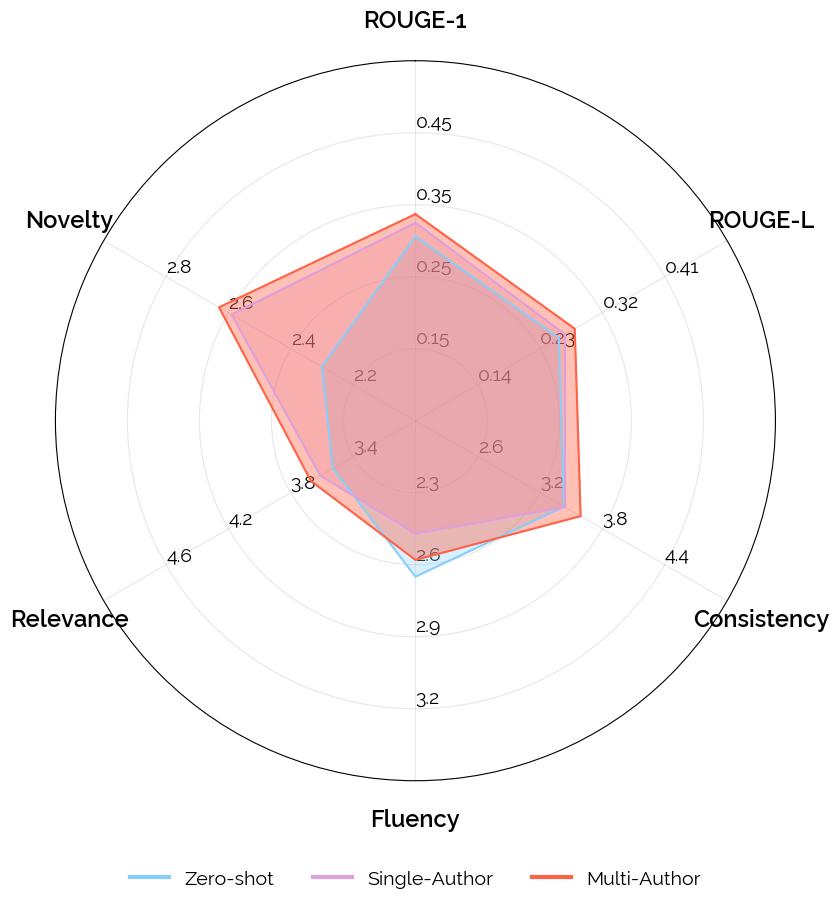

/tmp/ipykernel_2282863/182905625.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


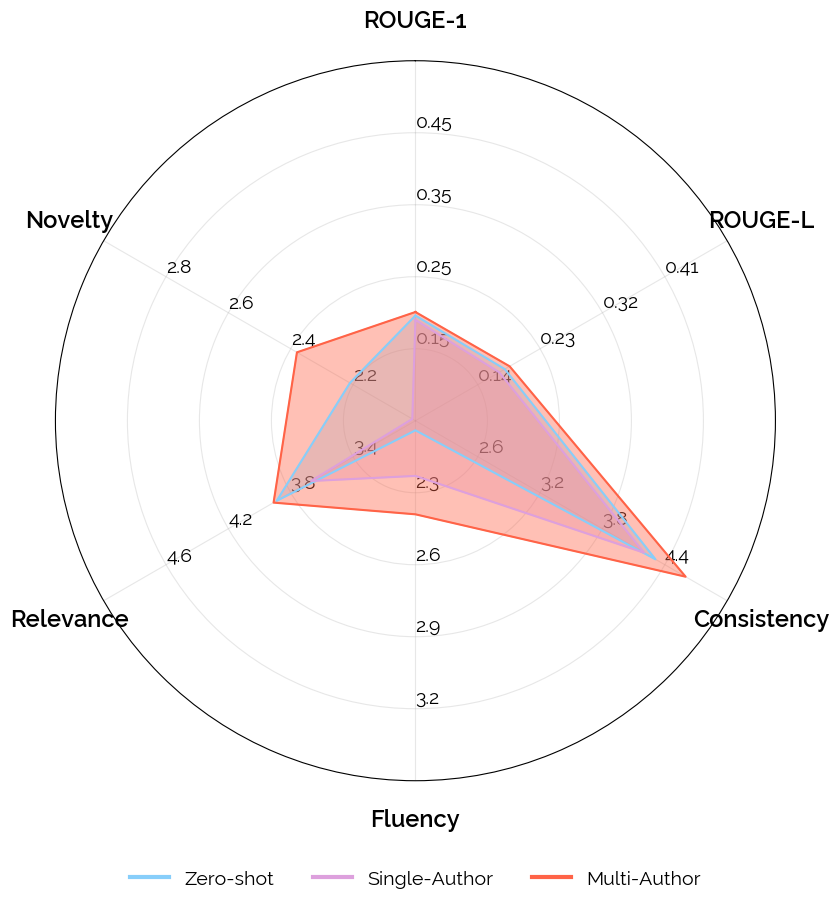

/tmp/ipykernel_2282863/182905625.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


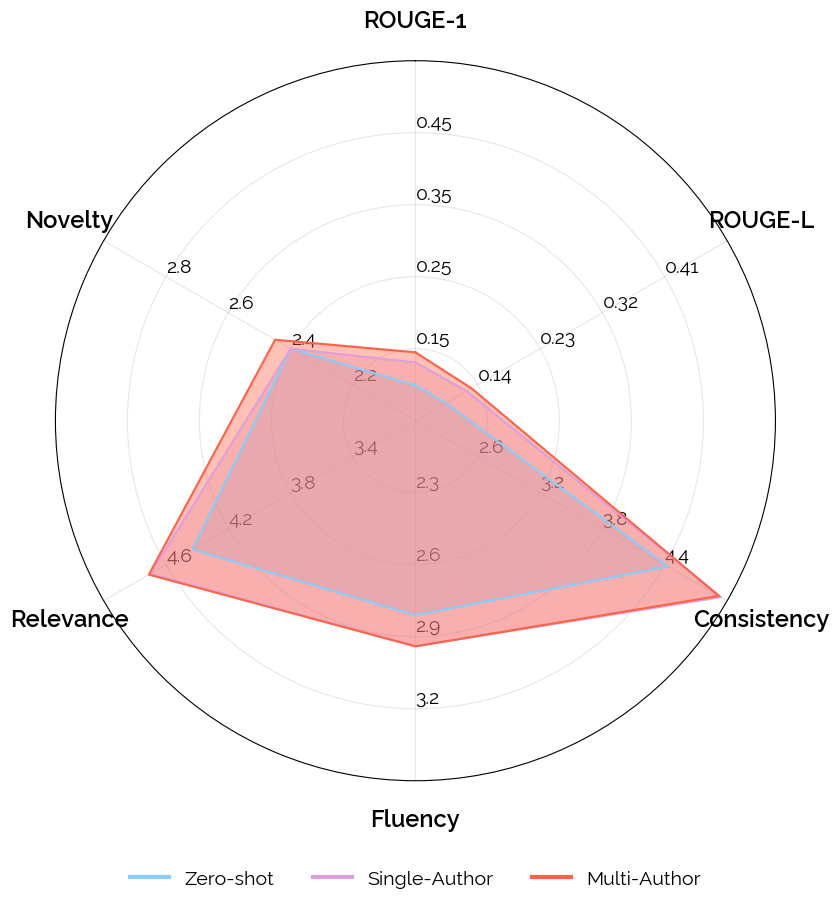

/tmp/ipykernel_2282863/182905625.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


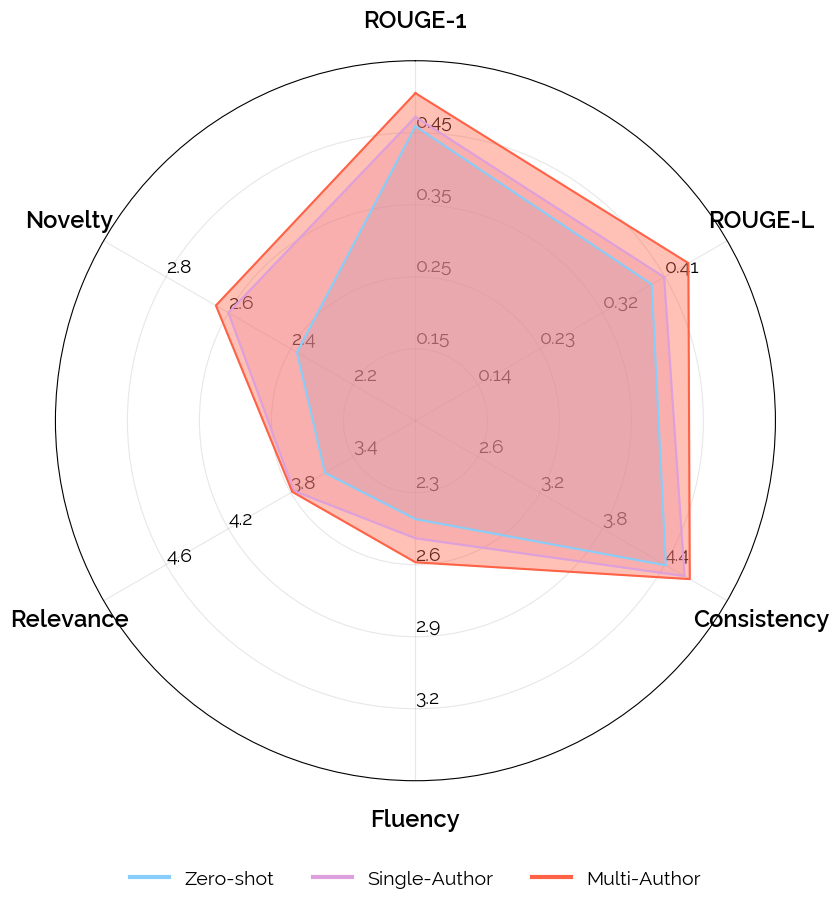

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming ComplexRadar class is already defined as per the provided code

# Data for the radar chart
labels = ["ROUGE-1", "ROUGE-L", "Consistency", "Fluency", "Relevance", "Novelty"]
datasets = ["PSW-1", "PSW-2", "PSW-3", "PSW-4"]
stats = {
    "PSW-1": {
        "Zero-shot": [0.306, 0.257, 3.43, 2.65, 3.53, 2.30],
        "Single-Author": [0.325, 0.266, 3.44, 2.47, 3.61, 2.59],
        "Multi-Author": [0.337, 0.280, 3.59, 2.58, 3.67, 2.63]
    },
    "PSW-2": {
        "Zero-shot": [0.196, 0.179, 4.31, 2.04, 3.89, 2.21],
        "Single-Author": [0.190, 0.171, 4.20, 2.23, 3.67, 2.01],
        "Multi-Author": [0.201, 0.186, 4.60, 2.39, 3.91, 2.38]
    },
    "PSW-3": {
        "Zero-shot": [0.099, 0.094, 4.43, 2.81, 4.43, 2.40],
        "Single-Author": [0.131, 0.124, 4.94, 2.94, 4.70, 2.40],
        "Multi-Author": [0.145, 0.131, 4.92, 2.94, 4.71, 2.45]
    },
    "PSW-4": {
        "Zero-shot": [0.459, 0.391, 4.41, 2.41, 3.58, 2.38],
        "Single-Author": [0.472, 0.409, 4.59, 2.49, 3.78, 2.60],
        "Multi-Author": [0.505, 0.444, 4.64, 2.59, 3.79, 2.64]
    }
}

# Define ranges for each metric to tighten the display range
ranges = [
    [0.05, 0.55],  # ROUGE-1
    [0.05, 0.5],   # ROUGE-L
    [2.0, 5.0],   # Consistency
    [2.0, 3.5],   # Fluency
    [3.0, 5.0],   # Relevance
    [2.0, 3.0]    # Novelty
]

# Format configuration for the radar chart
format_cfg = {
    'rad_ln_args': {'visible': True, 'alpha': 0.3},
    'angle_ln_args': {'visible': True, 'alpha': 0.3},
    'rgrid_tick_lbls_args': {'fontsize': 14},
    'theta_tick_lbls_pad': 18,
    'outer_ring': {'visible': True, 'color': '#000000'},
    'theta_tick_lbls': {'va': 'center', 'ha': 'center', 'fontsize': 17, 'fontweight': 550},
}

# Create radar charts for each dataset
for dataset in datasets:
    fig = plt.figure(figsize=(8, 8))
    radar = ComplexRadar(fig, labels, ranges, n_ring_levels=5, show_scales=True, format_cfg=format_cfg)

    custom_colors = ['#87CEFA', '#DDA0DD', '#FF6347']
    custom_alphas = [0.3, 0.3, 0.4]

    for i, (model, values) in enumerate(stats[dataset].items()):
        radar.plot(values, label=model, color=custom_colors[i])
        radar.fill(values, alpha=custom_alphas[i], color=custom_colors[i])

    radar.use_legend(**{'loc': 'upper center', 'bbox_to_anchor': (0.5, -0.1), 'ncol': 3, 'fontsize': 14, 'frameon': False})

    plt.tight_layout()
    plt.savefig(f'./{dataset}_radar_chart.pdf', dpi=300, bbox_inches='tight')
    plt.show()

/tmp/ipykernel_2282863/1084750490.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


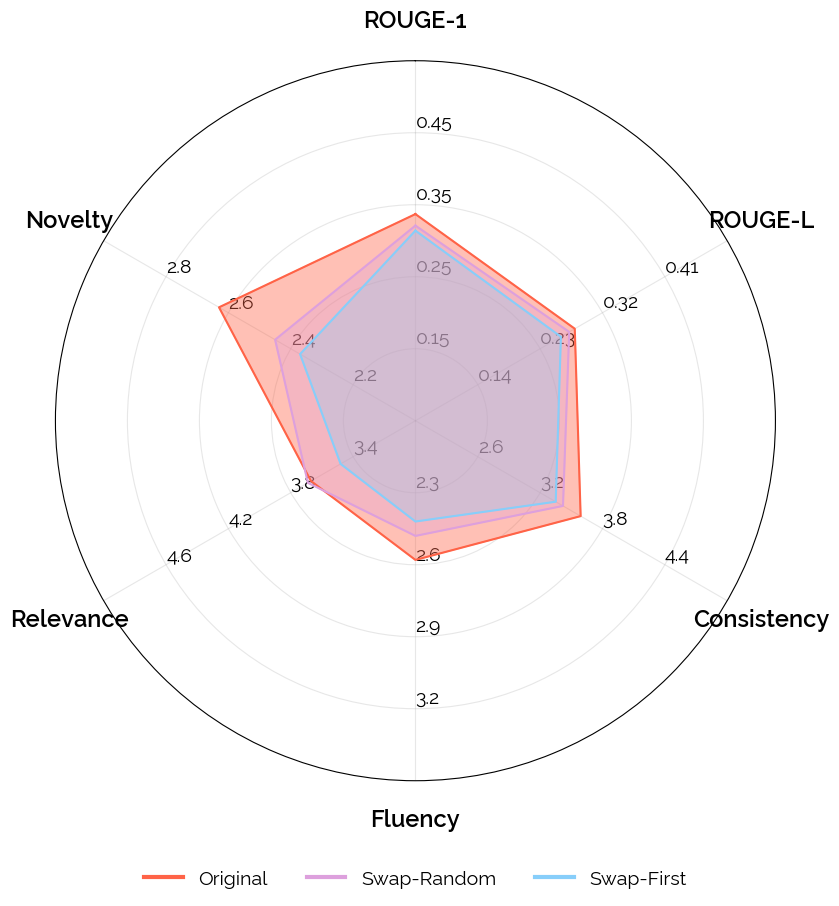

/tmp/ipykernel_2282863/1084750490.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


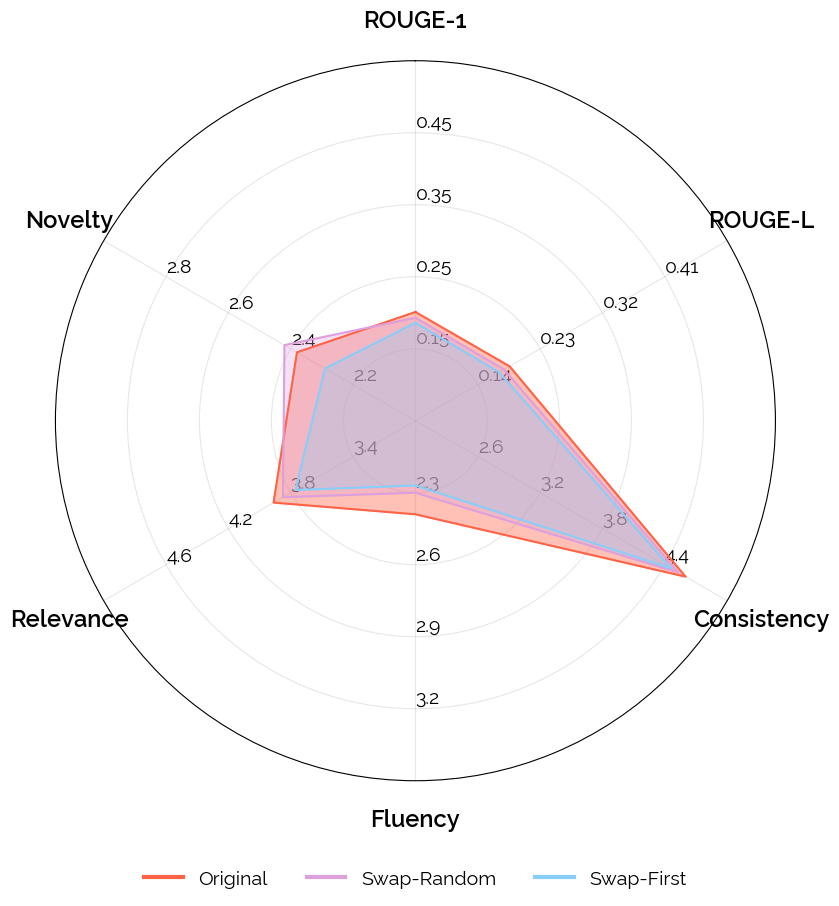

/tmp/ipykernel_2282863/1084750490.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


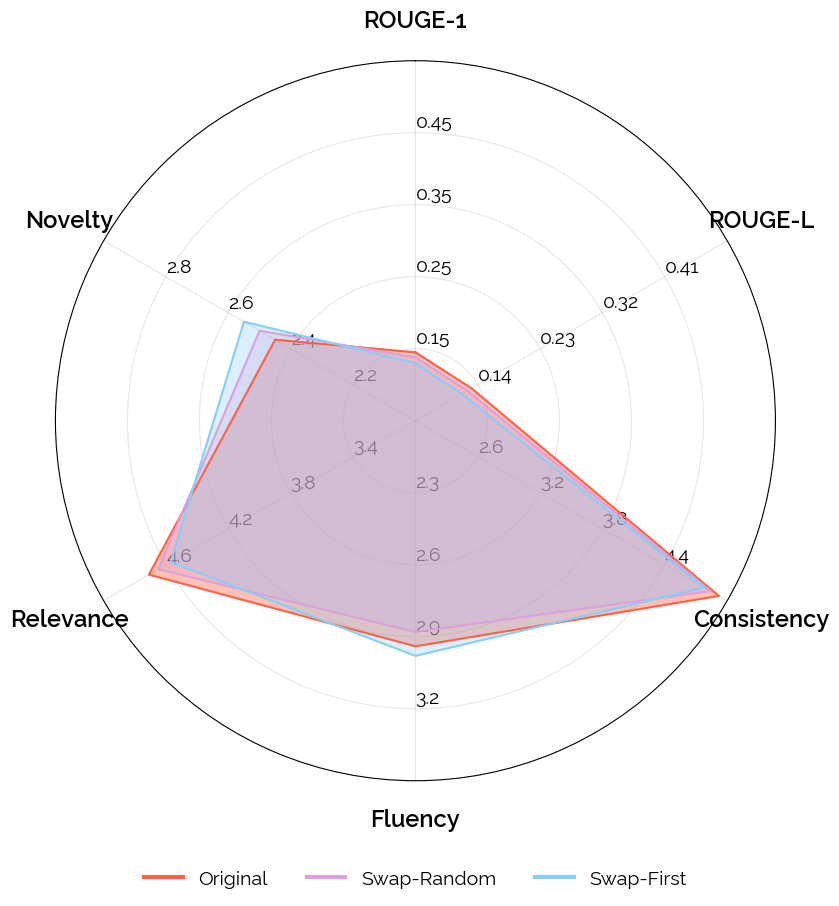

/tmp/ipykernel_2282863/1084750490.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


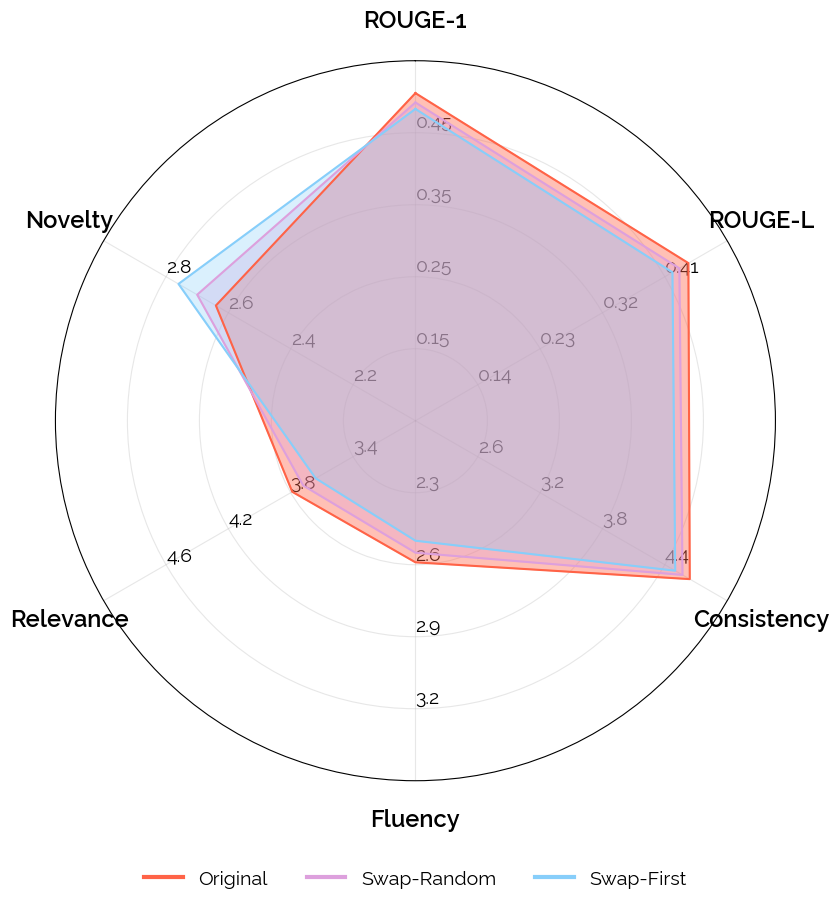

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming ComplexRadar class is already defined as per the provided code

# Data for the radar chart
labels = ["ROUGE-1", "ROUGE-L", "Consistency", "Fluency", "Relevance", "Novelty"]
datasets = ["PSW-1", "PSW-2", "PSW-3", "PSW-4"]
stats = {
    "PSW-1": {
        "Original": [0.337, 0.280, 3.59, 2.58, 3.67, 2.63],
        "Swap-Random": [0.321, 0.272, 3.42, 2.48, 3.69, 2.45],
        "Swap-First": [0.314, 0.260, 3.35, 2.42, 3.48, 2.37]
    },
    "PSW-2": {
        "Original": [0.201, 0.186, 4.60, 2.39, 3.91, 2.38],
        "Swap-Random": [0.193, 0.178, 4.53, 2.30, 3.85, 2.42],
        "Swap-First": [0.186, 0.171, 4.46, 2.27, 3.77, 2.29]
    },
    "PSW-3": {
        "Original": [0.145, 0.131, 4.92, 2.94, 4.71, 2.45],
        "Swap-Random": [0.138, 0.125, 4.84, 2.88, 4.65, 2.50],
        "Swap-First": [0.130, 0.117, 4.78, 2.98, 4.57, 2.55]
    },
    "PSW-4": {
        "Original": [0.505, 0.444, 4.64, 2.59, 3.79, 2.64],
        "Swap-Random": [0.492, 0.431, 4.57, 2.55, 3.72, 2.70],
        "Swap-First": [0.483, 0.421, 4.50, 2.50, 3.64, 2.76]
    }
}

# Define ranges for each metric to tighten the display range
ranges = [
    [0.05, 0.55],  # ROUGE-1
    [0.05, 0.5],   # ROUGE-L
    [2.0, 5.0],   # Consistency
    [2.0, 3.5],   # Fluency
    [3.0, 5.0],   # Relevance
    [2.0, 3.0]    # Novelty
]

# Format configuration for the radar chart
format_cfg = {
    'rad_ln_args': {'visible': True, 'alpha': 0.3},
    'angle_ln_args': {'visible': True, 'alpha': 0.3},
    'rgrid_tick_lbls_args': {'fontsize': 14},
    'theta_tick_lbls_pad': 18,
    'outer_ring': {'visible': True, 'color': '#000000'},
    'theta_tick_lbls': {'va': 'center', 'ha': 'center', 'fontsize': 17, 'fontweight': 550},
}

# Create radar charts for each dataset in ablation_1
for dataset in datasets:
    fig = plt.figure(figsize=(8, 8))
    radar = ComplexRadar(fig, labels, ranges, n_ring_levels=5, show_scales=True, format_cfg=format_cfg)

    custom_colors = ['#FF6347', '#DDA0DD', '#87CEFA']
    custom_alphas = [0.4, 0.3, 0.3]

    for i, (model, values) in enumerate(stats[dataset].items()):
        radar.plot(values, label=model, color=custom_colors[i])
        radar.fill(values, alpha=custom_alphas[i], color=custom_colors[i])

    radar.use_legend(**{'loc': 'upper center', 'bbox_to_anchor': (0.5, -0.1), 'ncol': 3, 'fontsize': 14, 'frameon': False})

    plt.tight_layout()
    plt.savefig(f'./{dataset}_ablation_1_radar_chart.pdf', dpi=300, bbox_inches='tight')
    plt.show()

/tmp/ipykernel_2282863/907724782.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


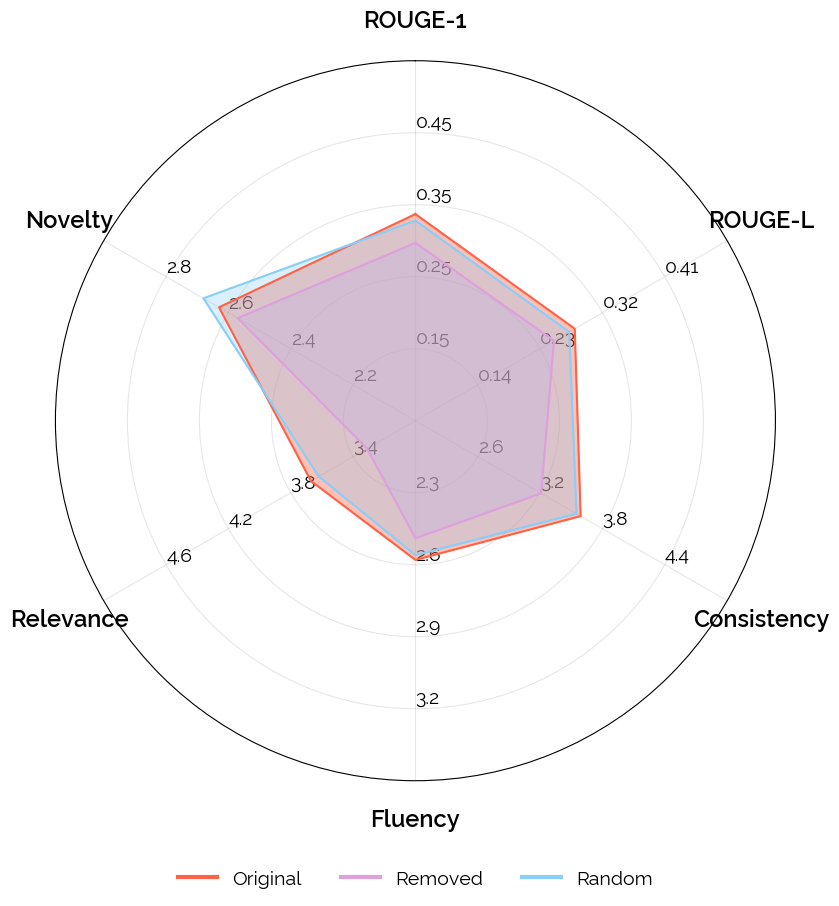

/tmp/ipykernel_2282863/907724782.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


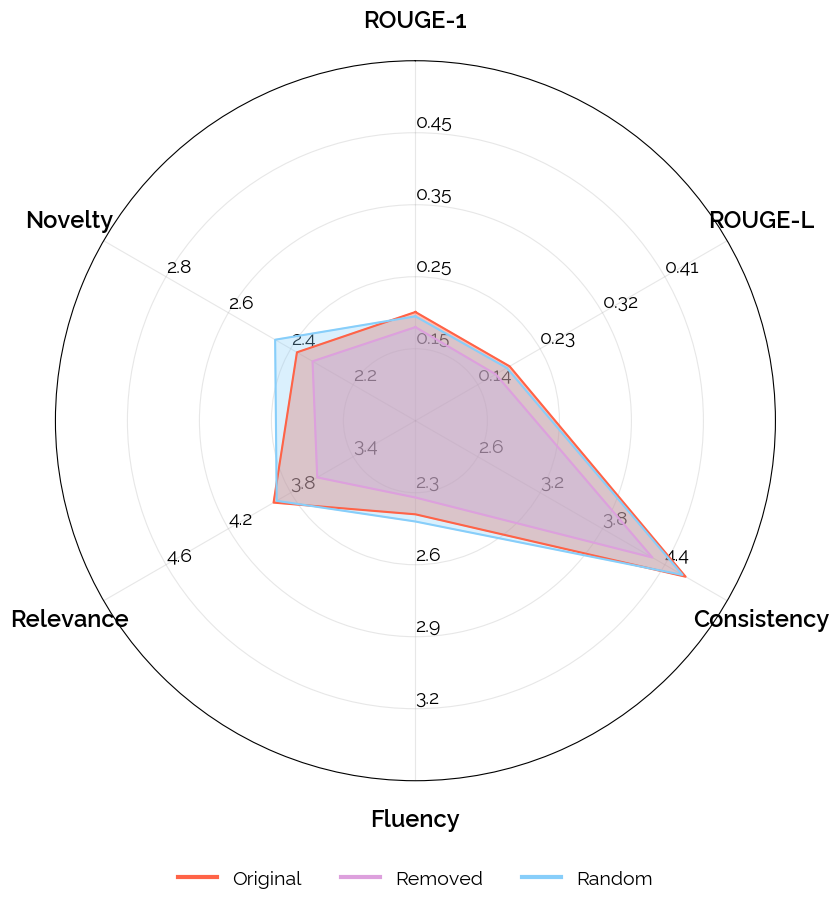

/tmp/ipykernel_2282863/907724782.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


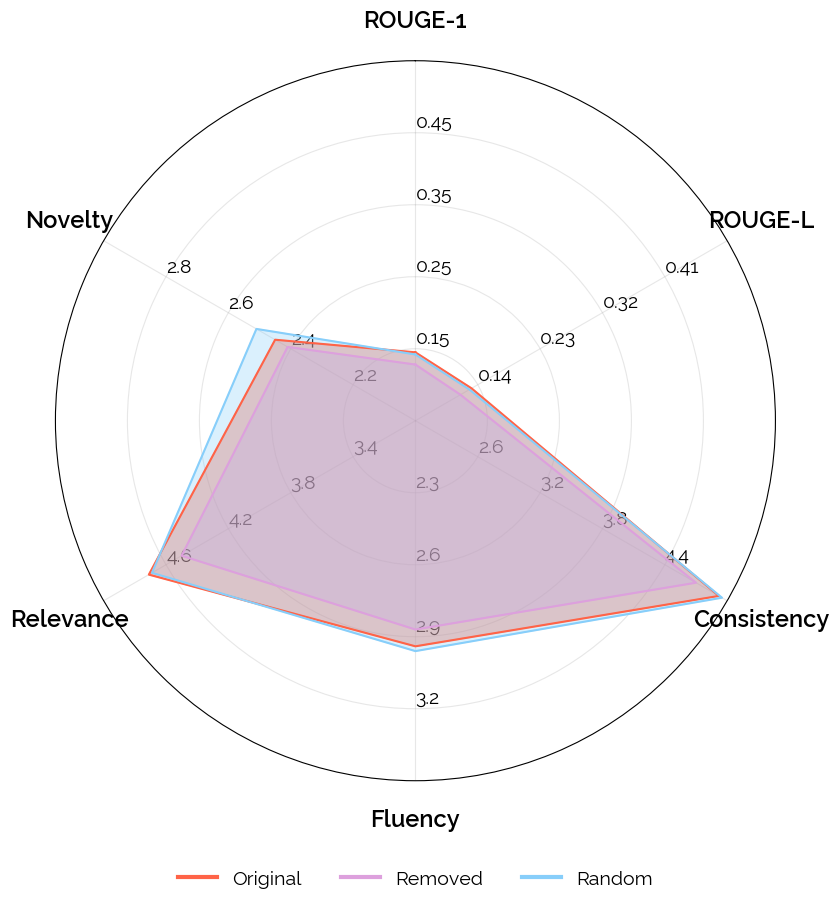

/tmp/ipykernel_2282863/907724782.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


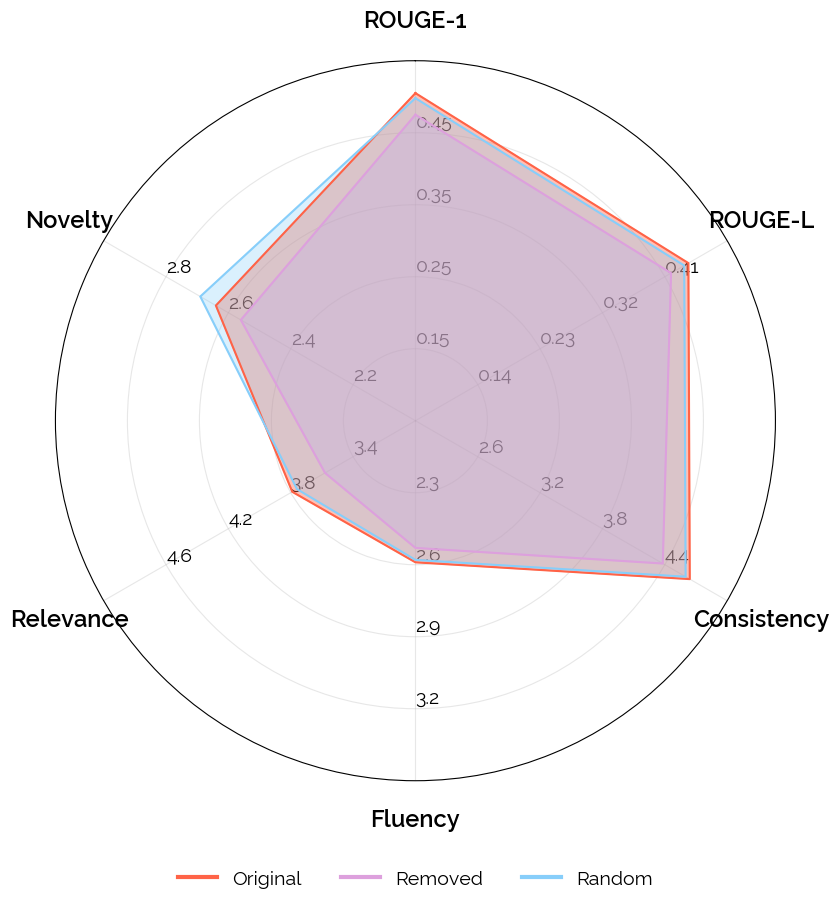

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming ComplexRadar class is already defined as per the provided code

# Data for the radar chart
labels = ["ROUGE-1", "ROUGE-L", "Consistency", "Fluency", "Relevance", "Novelty"]
datasets = ["PSW-1", "PSW-2", "PSW-3", "PSW-4"]
stats = {
    "PSW-1": {
        "Original": [0.337, 0.280, 3.59, 2.58, 3.67, 2.63],
        "Removed": [0.297, 0.250, 3.21, 2.49, 3.31, 2.57],
        "Random": [0.328, 0.272, 3.55, 2.56, 3.62, 2.68]
    },
    "PSW-2": {
        "Original": [0.201, 0.186, 4.60, 2.39, 3.91, 2.38],
        "Removed": [0.180, 0.166, 4.28, 2.32, 3.63, 2.33],
        "Random": [0.195, 0.182, 4.57, 2.42, 3.89, 2.45]
    },
    "PSW-3": {
        "Original": [0.145, 0.131, 4.92, 2.94, 4.71, 2.45],
        "Removed": [0.128, 0.115, 4.70, 2.87, 4.50, 2.41],
        "Random": [0.142, 0.128, 4.95, 2.96, 4.69, 2.51]
    },
    "PSW-4": {
        "Original": [0.505, 0.444, 4.64, 2.59, 3.79, 2.64],
        "Removed": [0.475, 0.419, 4.38, 2.53, 3.58, 2.56],
        "Random": [0.498, 0.438, 4.60, 2.58, 3.76, 2.69]
    }
}

# Define ranges for each metric to tighten the display range
ranges = [
    [0.05, 0.55],  # ROUGE-1
    [0.05, 0.5],   # ROUGE-L
    [2.0, 5.0],   # Consistency
    [2.0, 3.5],   # Fluency
    [3.0, 5.0],   # Relevance
    [2.0, 3.0]    # Novelty
]

# Format configuration for the radar chart
format_cfg = {
    'rad_ln_args': {'visible': True, 'alpha': 0.3},
    'angle_ln_args': {'visible': True, 'alpha': 0.3},
    'rgrid_tick_lbls_args': {'fontsize': 14},
    'theta_tick_lbls_pad': 18,
    'outer_ring': {'visible': True, 'color': '#000000'},
    'theta_tick_lbls': {'va': 'center', 'ha': 'center', 'fontsize': 17, 'fontweight': 550},
}

# Create radar charts for each dataset in ablation_2
for dataset in datasets:
    fig = plt.figure(figsize=(8, 8))
    radar = ComplexRadar(fig, labels, ranges, n_ring_levels=5, show_scales=True, format_cfg=format_cfg)

    custom_colors = ['#FF6347', '#DDA0DD', '#87CEFA']
    custom_alphas = [0.4, 0.3, 0.3]

    for i, (model, values) in enumerate(stats[dataset].items()):
        radar.plot(values, label=model, color=custom_colors[i])
        radar.fill(values, alpha=custom_alphas[i], color=custom_colors[i])

    radar.use_legend(**{'loc': 'upper center', 'bbox_to_anchor': (0.5, -0.1), 'ncol': 3, 'fontsize': 14, 'frameon': False})

    plt.tight_layout()
    plt.savefig(f'./{dataset}_ablation_2_radar_chart.pdf', dpi=300, bbox_inches='tight')
    plt.show()